In [15]:
import os
import numpy as np
import collections
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, np_utils
from keras.layers import Dense, Input, Embedding,Conv1D,MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, LSTM
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
#Import pre-trained word vector and form a dictionary in which words in the embedding set are mapped to their respective embedding vector

embeddings_dict = {}
glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    values = line.split()
    word = values[0]
    coefficients = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefficients
glove_file.close()

print('%s word-embedding_vectors added in dictonary' % len(embeddings_dict))

400000 word-embedding_vectors added in dictonary


In [3]:
#Import dataset.
df = pd.read_csv("globalenglish_essay_scoring.csv", encoding = 'latin1')
df = df[np.isfinite(df['domain1_score'])]
essay_text = df.essay

In [5]:
#Count words in longest essay so as to pad sentence to match length 
counter = collections.Counter()
maxlen = 0
minlen = 1000
for line in essay_text:
    sent = line.strip()
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    
    if len(words) < minlen:
        minlen = len(words)
        
    for word in words:
        counter[word] += 1
        
print ('%s words found in dataset' % len(counter.keys()))        
print('%s words in longest essay' % maxlen)
print('%s words in smallest essay' % minlen)

45026 words found in dataset
1204 words in longest essay
2 words in smallest essay


In [7]:
VOCAB_SIZE = 40000
EMBEDDING_DIM = 100
BATCH_SIZE = 128
NUM_EPOCHS = 10
NUM_FILTERS = 128
NUM_WORDS = 5
MAX_SEQ = 200

In [8]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(essay_text)
sequences = tokenizer.texts_to_sequences(essay_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=MAX_SEQ)
eset = df.essay_set.values.reshape(df.essay_set.shape[0], 1)
X = np.append(X, eset, 1)
MAX_SEQ = MAX_SEQ + 1

#Convert labels into one hot matrix
score = df.domain1_score
Y = np_utils.to_categorical(score)

print('Shape of input data:', X.shape)
print('Shape of label:', Y.shape)

Found 41432 unique tokens.
Shape of input data: (12977, 201)
Shape of label: (12977, 61)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(10381, 201) (2596, 201) (10381, 61) (2596, 61)


In [10]:
# prepare embedding matrix
num_words = len(word_index)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_SEQ:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ,
                            trainable=True)


In [13]:
class AttentionWithContext(Layer):
    
    def __init__(self, init='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None,  **kwargs):
        self.supports_masking = True
        self.init = initializers.get(init)
        self.kernel_initializer = initializers.get('glorot_uniform')

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight((input_shape[-1], 1),
                                 initializer=self.kernel_initializer,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.b = self.add_weight((input_shape[1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name),
                                 regularizer=self.bias_regularizer,
                                 constraint=self.bias_constraint)

        self.u = self.add_weight((input_shape[1],),
                                 initializer=self.kernel_initializer,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)
        self.built = True

    def compute_mask(self, input, mask):
        return None

    def call(self, x, mask=None):
        multData =  K.dot(x, self.kernel)
        multData = K.squeeze(multData, -1)
        multData = multData + self.b 

        multData = K.tanh(multData) 

        multData = multData * self.u
        multData = K.exp(multData) 


        if mask is not None:
            mask = K.cast(mask, K.floatx())
            multData = mask*multData 

        multData /= K.cast(K.sum(multData, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        multData = K.expand_dims(multData)
        weighted_input = x * multData
        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1],)

In [19]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQ, trainable=True))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=None, padding='valid'))

model.add(LSTM(MAX_SEQ,return_sequences=True))
model.add(AttentionWithContext())

model.add(Dense(61, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(61, activation="softmax"))

In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("PT_CNN", monitor='val_acc', mode='auto', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)

history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, Ytest), callbacks=[checkpoint, earlyStopping, reduceLR])

Train on 10381 samples, validate on 2596 samples
Epoch 1/10
10381/10381 [==============================] - 70s 7ms/step - loss: 2.6311 - acc: 0.3033 - val_loss: 1.8888 - val_acc: 0.4284

Epoch 00001: val_acc improved from -inf to 0.42835, saving model to PT_CNN
Epoch 2/10
10381/10381 [==============================] - 66s 6ms/step - loss: 1.8508 - acc: 0.4148 - val_loss: 1.6457 - val_acc: 0.4615

Epoch 00002: val_acc improved from 0.42835 to 0.46148, saving model to PT_CNN
Epoch 3/10
10381/10381 [==============================] - 65s 6ms/step - loss: 1.6365 - acc: 0.4500 - val_loss: 1.4686 - val_acc: 0.4946

Epoch 00003: val_acc improved from 0.46148 to 0.49461, saving model to PT_CNN
Epoch 4/10
10381/10381 [==============================] - 63s 6ms/step - loss: 1.4916 - acc: 0.4764 - val_loss: 1.3956 - val_acc: 0.4985

Epoch 00004: val_acc improved from 0.49461 to 0.49846, saving model to PT_CNN
Epoch 5/10
10381/10381 [==============================] - 65s 6ms/step - loss: 1.4027 - ac

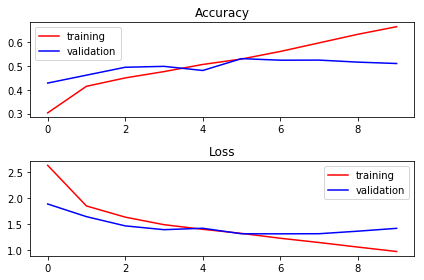

In [21]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="training")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="training")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 201, 100)          4143200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 197, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 39, 201)           265320    
_________________________________________________________________
attention_with_context_2 (At (None, 201)               279       
_________________________________________________________________
dense_3 (Dense)              (None, 61)                12322     
_________________________________________________________________
dropout_2 (Dropout)          (None, 61)                0         
__________